# Assign 1 - Deep Learning
Jonathan Menahem - 203772611 <br>
Alon Mazri - 

Help Source: [https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/](https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import imagesize
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.layers.experimental.preprocessing as preprocessing

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Exploring The Data

In [3]:
# Get the Image Resolutions
root_path = 'chest_xray\\train\\PNEUMONIA\\'
imgs = [img.name for img in Path(root_path).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root_path+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 3883


,FileName,Size,Width,Height,Aspect Ratio
0,person1000_bacteria_2931.jpeg,"(1152, 760)",1152,760,1.52
1,person1000_virus_1681.jpeg,"(1072, 768)",1072,768,1.40
2,person1001_bacteria_2932.jpeg,"(1244, 863)",1244,863,1.44
3,person1002_bacteria_2933.jpeg,"(1242, 940)",1242,940,1.32
4,person1003_bacteria_2934.jpeg,"(1488, 1280)",1488,1280,1.16


In [4]:
print("min width:", img_meta_df["Width"].min())
print("min height:", img_meta_df["Height"].min())

min width: 384
min height: 127


Text(0, 0.5, 'Height')

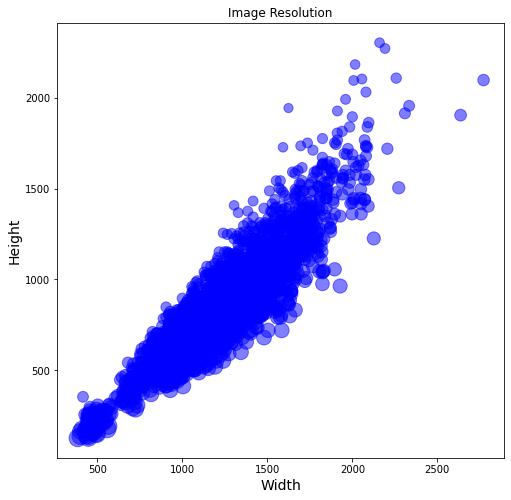

In [5]:
# Visualize Image Resolutions

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

# Loading The Data

In [6]:
image_size=(200, 200)
train_directory = 'chest_xray/train'
test_directory = 'chest_xray/test'
seed = np.random.randint(50, dtype=int)

# these are all default input values from documentation
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='grayscale', batch_size=32, image_size=image_size,
    shuffle=True, seed=seed, validation_split=0.15, subset='training',
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='grayscale', batch_size=32, image_size=image_size, 
    shuffle=True, seed=seed, validation_split=0.15, subset='validation',
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

# these are all default input values from documentation
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='grayscale', batch_size=32, image_size=image_size,
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5232 files belonging to 2 classes.
Using 4448 files for training.
Found 5232 files belonging to 2 classes.
Using 784 files for validation.
Found 624 files belonging to 2 classes.


In [7]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 1)
(32, 2)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = validation_data.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_data.map(lambda x, y: (normalization_layer(x), y))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
train_labels = np.array([])

for x, y in train_data:
    train_labels = np.concatenate([train_labels, np.argmax(y.numpy(), axis = -1)])

val_labels =  np.array([])

for x, y in validation_data:
    val_labels = np.concatenate([val_labels, np.argmax(y.numpy(), axis = -1)])

test_labels =  np.array([])

for x, y in test_data:
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])


print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Labels Shape:", test_labels.shape)

Train Labels Shape: (4448,)
Validation Labels Shape: (784,)
Test Labels Shape: (624,)


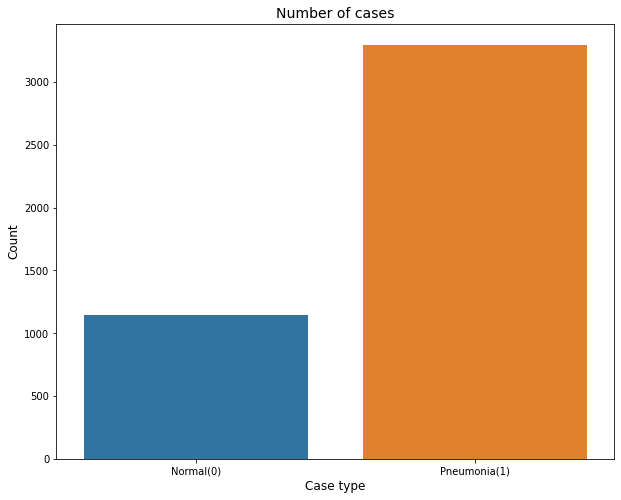

In [11]:
cases_count = np.unique(train_labels, return_counts=True)
val_cases_count = np.unique(val_labels, return_counts=True)


# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count[0], y=cases_count[1])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

As you can see the data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. <br>
This situation is very normal when it comes to medical data. The data will always be imbalanced. <br>
either there will be too many normal cases or there will be too many cases with the disease.

# Correcting imbalanced data using weights

In [12]:
COUNT_NORMAL = cases_count[1][0]
COUNT_PNEUMONIA = cases_count[1][1]
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
VAL_IMG_COUNT = np.sum(val_cases_count[1])

initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.05472739])

In [13]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


# Basic Model (without convolution layers)

In [ ]:
num_classes = 2
input_shape = (300, 300, 1)

basic_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(10, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(6, activation="relu"),
        layers.Flatten(),
        layers.Dropout(0.15),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300, 300, 10)      20        
                                                                 
 dense_1 (Dense)             (None, 300, 300, 8)       88        
                                                                 
 dense_2 (Dense)             (None, 300, 300, 6)       54        
                                                                 
 flatten (Flatten)           (None, 540000)            0         
                                                                 
 dropout (Dropout)           (None, 540000)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1080002   
                                                                 
Total params: 1,080,164
Trainable params: 1,080,164
Non-

In [ ]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [ ]:
epochs = 20

callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

basic_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

basic_history = basic_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, class_weight=class_weight)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 [==============================] - 8s 41ms/step - loss: 1.0095 - accuracy: 0.8159 - precision: 0.8159 - recall: 0.8159 - val_loss: 0.1930 - val_accuracy: 0.9273 - val_precision: 0.9273 - val_recall: 0.9273 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 [==============================] - 5s 34ms/step - loss: 0.1645 - accuracy: 0.9341 - precision: 0.9341 - recall: 0.9341 - val_loss: 0.1509 - val_accuracy: 0.9464 - val_precision: 0.9464 - val_recall: 0.9464 - lr: 8.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 [==============================] - 5s 32ms/step - loss: 0.1292 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508 - val_loss: 0.1438 - val_accuracy: 0.9464 - val_precision: 0.9464 - val_recall: 0.9464 - lr: 6.1413e-04

Epoch 00004: LearningRate

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])


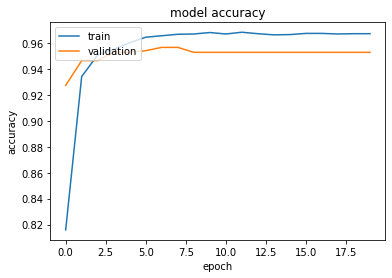

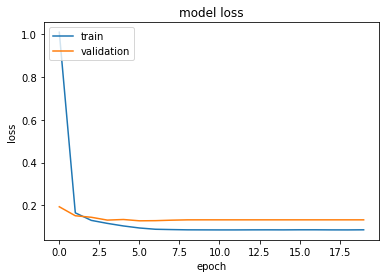

In [ ]:
# list all data in history
print(basic_history.history.keys())
# summarize history for accuracy
plt.plot(basic_history.history['accuracy'])
plt.plot(basic_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(basic_history.history['loss'])
plt.plot(basic_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy, precision, recall = basic_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Test precision:", precision)
print("Test recall:", recall)

20/20 [==============================] - 0s 15ms/step - loss: 0.6368 - accuracy: 0.7740 - precision: 0.7740 - recall: 0.7740
Test loss: 0.636758029460907
Test accuracy: 0.7740384340286255
Test precision: 0.7740384340286255
Test recall: 0.7740384340286255


In [ ]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(basic_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


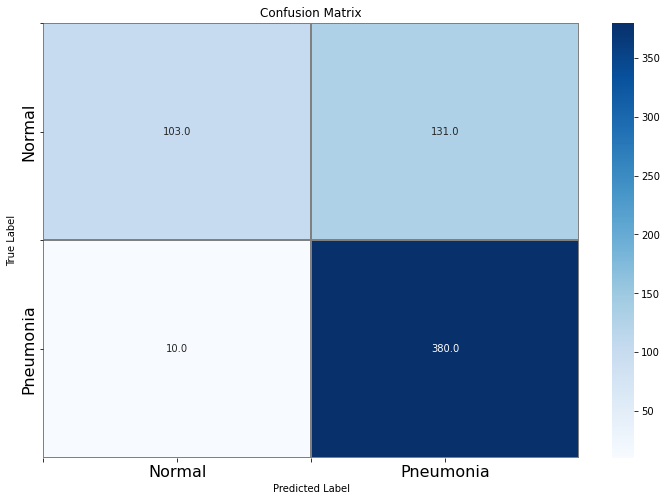

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal', '', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal', '', 'Pneumonia'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Advanced Model (using convolution layers)

In [ ]:
num_classes = 2
input_shape = (300, 300, 1)

advanced_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", strides=(2, 2), padding='same'),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", strides=(2, 2), padding='same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", strides=(1, 1), padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(50, activation="relu"),
        layers.Dense(15, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
) 

In [ ]:
advanced_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 256)      0         
 2D)                                                    

In [ ]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [ ]:
BATCH_SIZE = 32

EPOCHS = 20

early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

callbacks = [learning_rate, early_stopping]

METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

advanced_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

advanced_history = advanced_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, class_weight=class_weight, 
                                      steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE, validation_steps=VAL_IMG_COUNT // BATCH_SIZE)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 [==============================] - 13s 64ms/step - loss: 0.3435 - accuracy: 0.8343 - precision: 0.8343 - recall: 0.8343 - val_loss: 0.3218 - val_accuracy: 0.8594 - val_precision: 0.8594 - val_recall: 0.8594 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 [==============================] - 8s 59ms/step - loss: 0.1140 - accuracy: 0.9575 - precision: 0.9575 - recall: 0.9575 - val_loss: 0.0881 - val_accuracy: 0.9635 - val_precision: 0.9635 - val_recall: 0.9635 - lr: 8.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 [==============================] - 8s 59ms/step - loss: 0.0764 - accuracy: 0.9730 - precision: 0.9730 - recall: 0.9730 - val_loss: 0.0715 - val_accuracy: 0.9753 - val_precision: 0.9753 - val_recall: 0.9753 - lr: 6.1413e-04

Epoch 00004: LearningRat

In [ ]:
loss, accuracy, precision, recall = advanced_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Test precision:", precision)
print("Test recall:", recall)

20/20 [==============================] - 1s 43ms/step - loss: 1.4244 - accuracy: 0.7612 - precision: 0.7612 - recall: 0.7612
Test loss: 1.4244252443313599
Test accuracy: 0.7612179517745972
Test precision: 0.7612179517745972
Test recall: 0.7612179517745972


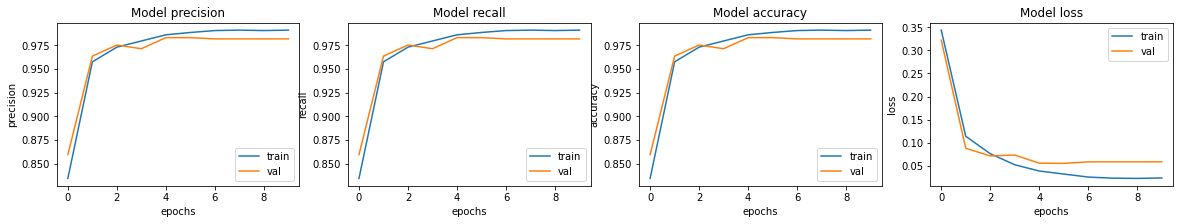

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(advanced_history.history[met])
    ax[i].plot(advanced_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(advanced_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


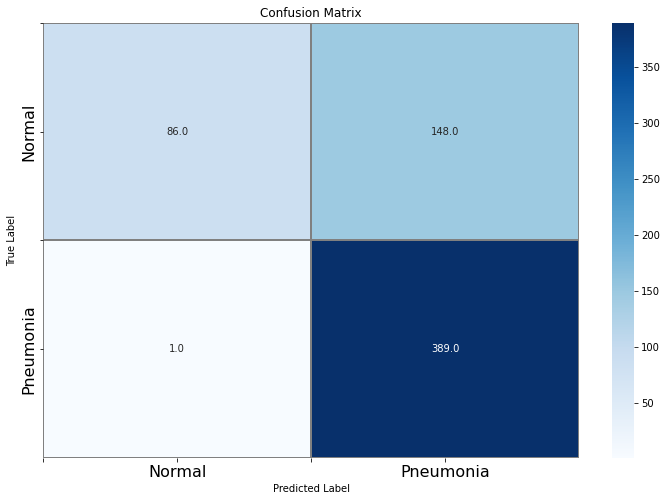

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal', '', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal', '', 'Pneumonia'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Data Augmentation 

In [14]:
num_classes = 2
input_shape = (200, 200, 1)

augmentation_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        
        # Data Augmentation
        preprocessing.RandomContrast(0.3),
        preprocessing.RandomRotation(0.18),
        preprocessing.RandomZoom(0.21),
        
        # body
        layers.BatchNormalization(),
        
        layers.Conv2D(64, kernel_size=(3,3) , strides=(1, 1) , padding = 'same' , activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2) , strides=(2, 2) , padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3,3) , strides=(1, 1) , padding = 'same' , activation = 'relu'),
        layers.Dropout(0.2),
        layers.MaxPooling2D(pool_size=(2,2) , strides=(2, 2) , padding = 'same'),
        
        layers.Conv2D(64, kernel_size=(3,3) , strides=(1, 1) , padding = 'same' , activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2) , strides=(2, 2) , padding = 'same'),
        layers.Dropout(0.1),
        
        layers.Conv2D(128, kernel_size=(3,3) , strides=(1, 1) , padding = 'same', activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2,2) , strides=(2, 2) , padding = 'same'),

        # Head
        layers.Flatten(),
        layers.Dense(units = 128, activation = 'relu'),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation = 'sigmoid'),
    ]
) 

In [15]:
augmentation_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 200, 200, 1)      0         
 rast)                                                           
                                                                 
 random_rotation (RandomRota  (None, 200, 200, 1)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 200, 200, 1)       0         
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 64)      640       
                                                        

In [16]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [17]:
BATCH_SIZE = 64

EPOCHS = 40

early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

callbacks = [learning_rate, early_stopping]

METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

augmentation_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

augmentation_history = augmentation_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, class_weight=class_weight)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/40
139/139 [==============================] - 11s 51ms/step - loss: 0.4958 - accuracy: 0.6790 - precision: 0.6600 - recall: 0.7048 - val_loss: 0.4403 - val_accuracy: 0.7832 - val_precision: 0.7947 - val_recall: 0.7602 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/40
139/139 [==============================] - 6s 44ms/step - loss: 0.2653 - accuracy: 0.9036 - precision: 0.9034 - recall: 0.9018 - val_loss: 0.2698 - val_accuracy: 0.9171 - val_precision: 0.9205 - val_recall: 0.9158 - lr: 8.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/40
139/139 [==============================] - 6s 44ms/step - loss: 0.2103 - accuracy: 0.9191 - precision: 0.9205 - recall: 0.9193 - val_loss: 0.3090 - val_accuracy: 0.8763 - val_precision: 0.8784 - val_recall: 0.8750 - lr: 6.1413e-04

Epoch 00004: LearningRat

In [18]:
loss, accuracy, precision, recall = augmentation_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Test precision:", precision)
print("Test recall:", recall)

20/20 [==============================] - 1s 20ms/step - loss: 0.2885 - accuracy: 0.8942 - precision: 0.8937 - recall: 0.8894
Test loss: 0.2885046601295471
Test accuracy: 0.8942307829856873
Test precision: 0.8937197923660278
Test recall: 0.8894230723381042


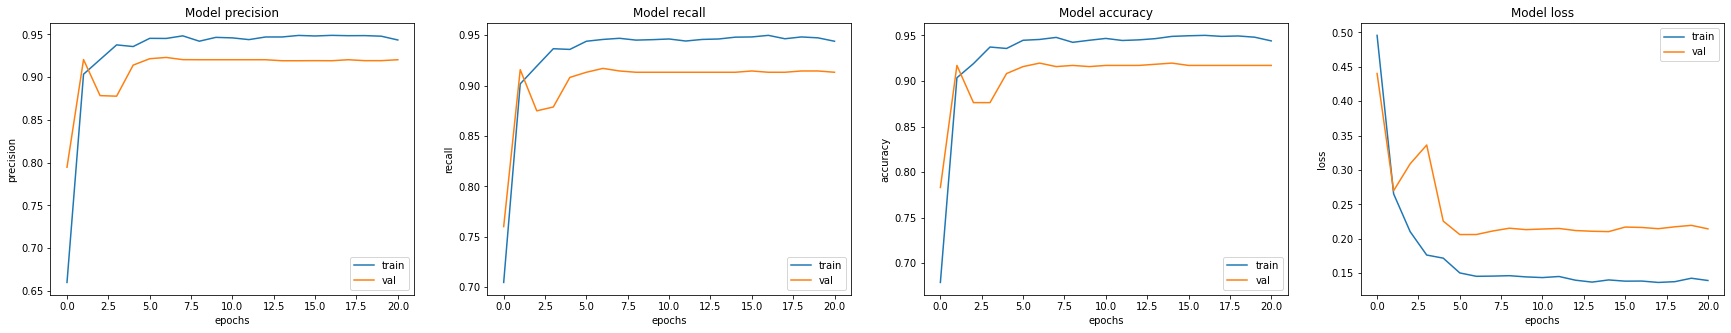

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(30, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(augmentation_history.history[met])
    ax[i].plot(augmentation_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(augmentation_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


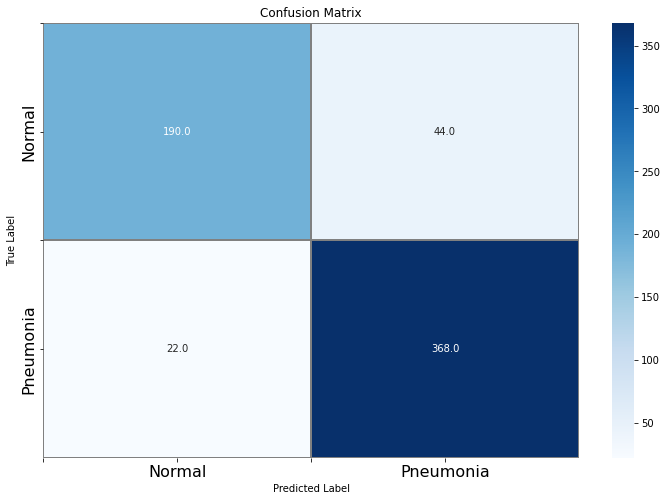

In [21]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal', '', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal', '', 'Pneumonia'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()